# Business Understanding

### Flatiron LLC has recently been awarded a contract to maintain wells in Tanzania. They're looking for a system to help develop preventative maintenance schedules by predicting pump failures to better server their end users. 

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import numpy as np
from graphviz import *
import pickle
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.feature_selection import SelectKBest, chi2

pd.set_option('display.max_columns', 999)

### EDA

In [2]:
df_training_labels = pd.read_csv('data/Training_set_labels.csv')
df_training_labels['id_2'] = df_training_labels['id']
df_training_labels.drop('id', axis = 1, inplace = True)
df_training_labels['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [3]:
df_training_values = pd.read_csv('data/Training_set_values.csv')

In [4]:
df_training_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status_group  59400 non-null  object
 1   id_2          59400 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [5]:
df_training_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

### joining tables

In [6]:
df = pd.concat([df_training_values, df_training_labels], join = 'inner', axis = 1)
df.drop('scheme_name', axis = 1, inplace = True)

### exploring null values

In [7]:
df.isna().sum()

id                          0
amount_tsh                  0
date_recorded               0
funder                   3635
gps_height                  0
installer                3655
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                371
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3334
recorded_by                 0
scheme_management        3877
permit                   3056
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_g

In [8]:
df['funder'].fillna(df['funder'].value_counts().index[0], inplace = True)

In [9]:
df['installer'].fillna(df['installer'].value_counts().index[0], inplace = True)

In [10]:
df['subvillage'].fillna(df['subvillage'].value_counts().index[0], inplace = True)

In [11]:
df['public_meeting'].fillna(df['public_meeting'].value_counts().index[0], inplace = True)

In [12]:
df['scheme_management'].fillna(df['scheme_management'].value_counts().index[0], inplace = True)

In [13]:
df['permit'].fillna(df['permit'].value_counts().index[0], inplace = True)

In [14]:
df['public_meeting']

0        True
1        True
2        True
3        True
4        True
         ... 
59395    True
59396    True
59397    True
59398    True
59399    True
Name: public_meeting, Length: 59400, dtype: bool

In [15]:
# mask = df.applymap(type) != bool
# d = {True: 'True', False: 'False'}

# df = df.where(mask, df.replace(d))

In [16]:
# pf = PolynomialFeatures(degree=2)

# X = df_no_cats

# pf.fit(X)
# pdf = pd.DataFrame(pf.transform(X), columns=pf.get_feature_names(X.columns))
# pdf
# corr_df = pdf.corr()
# corr_df[corr_df['x0'] > .75]['x0']

### Verifying merge tables match based on ID number and reviewing total rows

In [17]:
df = df[df['id'] == df['id_2']]

In [18]:
df.drop(['id_2'], axis = 1, inplace = True)
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,GeoData Consultants Ltd,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,VWC,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


### Dropping unwanted rows

In [19]:
df.drop(['id', 'date_recorded', 'longitude', 'latitude'], axis = 1, inplace = True)

In [20]:
df['waterpoint_type'].value_counts()

communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64

In [21]:
df_3 = df[df['installer'].map(df['installer'].value_counts()) > 300]
df_3['installer'].value_counts()

DWE                   21057
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
LGA                     408
World vision            408
WEDECO                  397
TASAF                   396
District council        392
Gover                   383
AMREF                   329
TWESA                   316
WU                      301
Name: installer, dtype: int64

In [22]:
df_4 = df[df['wpt_name'].map(df['wpt_name'].value_counts()) > 100]
df_4['wpt_name'].value_counts()

none               3563
Shuleni            1748
Zahanati            830
Msikitini           535
Kanisani            323
Bombani             271
Sokoni              260
Ofisini             254
School              208
Shule Ya Msingi     199
Shule               152
Sekondari           146
Muungano            133
Mkombozi            111
Madukani            104
Name: wpt_name, dtype: int64

In [23]:
def get_totals(dataframe, filter_column, filter_groupby):

        '''
        **** filter_column & filter_groupby need to be passed
        as strings ****

        1. get_totals will calculate the sum of the variables
        within a column and return a new column with the 
        sum of their total occurances in the dataframe
        
        2. get_totals will calulate the percentage of the 
        values column vs the total values

        dataframe = pandas dataframe
        filter_column = column to filter by
        filter_groupby = groupby column to filter by

        '''

        df_new = pd.DataFrame(dataframe.groupby(filter_groupby)[filter_column].value_counts())
        df_new[f'{filter_groupby}_values'] = df_new[filter_column]
        df_new.drop(filter_column, axis = 1, inplace = True)
        df_new.reset_index(inplace = True)

        types = set()

        for idx, value in enumerate(df_new[f'{filter_groupby}_values']):
            for type_ in df_new[filter_column]:
                types.add(type_)
            
        total_values = {}
            
        for value in types:
            total_values[value] = df_new[df_new[filter_column] == value][f'{filter_groupby}_values'].sum()

        df_new[f'{filter_groupby}_total_values'] = df_new[filter_column].map(total_values)

        df_new[f'{filter_groupby}_percentage'] = df_new[f'{filter_groupby}_values'] / df_new[f'{filter_groupby}_total_values']
            
        return df_new


In [24]:
# function_df = df.drop('status_group', axis = 1)

# percentage_dict = {}

# for idx, column in enumerate(function_df.columns):
#     percentage_dict[column] = get_totals(df, column, 'status_group')

# pickle_out = open('percentage_dict.pickle', 'wb')
# pickle.dump(percentage_dict, pickle_out)

In [25]:
pickle_in = open('percentage_dict.pickle', 'rb')

percentage_dict = pickle.load(pickle_in)

In [26]:
df.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [27]:
percentage_dict['quality_group']

,status_group,quality_group,status_group_values,status_group_total_values,status_group_percentage
0,functional,good,28760,50818,0.565941
1,functional,salty,2394,5195,0.460828
2,functional,milky,438,804,0.544776
3,functional,unknown,264,1876,0.140725
4,functional,colored,246,490,0.502041
5,functional,fluoride,157,217,0.723502
6,functional needs repair,good,3904,50818,0.076823
7,functional needs repair,salty,297,5195,0.057170
8,functional needs repair,colored,54,490,0.110204
9,functional needs repair,unknown,35,1876,0.018657


In [28]:
# stat_group = df['status_group'].value_counts().index.to_list()

# for column in df:
#     fig, ax = plt.subplots(figsize = (5,5))
#     x = []
#     y = []
#     for stat in stat_group:
#         y.append(df.groupby('status_group')[column].value_counts()[stat].values.sum())
#         x.append(stat)
#     plt.title(column)
#     ax.bar(x, y)
#     plt.xticks(rotation=45, ha = 'right')

In [29]:
# for i in df:
#     print('------- {} -------'.format(i))
#     print(df.groupby('status_group')[i].value_counts())

### First Simple Model

In [30]:
X_fsm = df.select_dtypes(['int64', 'float64'])
y_fsm = df['status_group']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_fsm,y_fsm, random_state = 42)

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

DecisionTreeClassifier()

In [32]:
dtc.score(X_train, y_train)

0.8497418630751964

In [33]:
dtc.feature_importances_

array([0.09759227, 0.38225384, 0.00472659, 0.08500769, 0.06949134,
       0.2120428 , 0.14888546])

In [34]:
dtc.n_features_

7

In [35]:
dtc.classes_

array(['functional', 'functional needs repair', 'non functional'],
      dtype=object)

In [36]:
dtc.score(X_test, y_test)

0.6417508417508417

In [37]:
dtc.feature_importances_

array([0.09759227, 0.38225384, 0.00472659, 0.08500769, 0.06949134,
       0.2120428 , 0.14888546])

### Model Exploration

In [38]:
X = df.drop('status_group', axis = 1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify=y)

In [39]:
# numeric_features = [
#  'amount_tsh',
#  'gps_height',
#  'num_private',
#  'population']

# numeric_transformer = Pipeline([('scaler', StandardScaler())])

# categorical_features = ['funder',
#  'installer',
#  'wpt_name',
#  'basin',
#  'subvillage',
#  'region',
#  'lga',
#  'ward',
#  'public_meeting',
#  'recorded_by',
#  'scheme_management',
#  'permit',
#  'extraction_type',
#  'extraction_type_group',
#  'extraction_type_class',
#  'management',
#  'management_group',
#  'payment',
#  'payment_type',
#  'water_quality',
#  'quality_group',
#  'quantity',
#  'quantity_group',
#  'source',
#  'source_type',
#  'source_class',
#  'waterpoint_type',
#  'waterpoint_type_group']

# categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
#                                ('cat', categorical_transformer, categorical_features)])

# clf = Pipeline([('preprocessor', preprocessor), 
#                ('classifier', LogisticRegression(max_iter = 10000))])

# clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'population']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['funder', 'installer',
                                                   'wpt_name', 'basin',
                                                   'subvillage', 'region',
                                                   'lga', 'ward',
                                                   'public_meeting',
                              

In [40]:
# clf.score(X_train, y_train)

0.9268911335578002

In [41]:
# X = df.drop('status_group', axis = 1)
# y = df['status_group']

In [42]:
# numeric_features = [
#  'amount_tsh',
#  'gps_height',
#  'num_private',
#  'population']

# numeric_transformer = Pipeline([('scaler', StandardScaler())])

# categorical_features = ['water_quality', 'source','waterpoint_type', 'quantity']


# categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
#                                ('cat', categorical_transformer, categorical_features)])

# clf = Pipeline([('preprocessor', preprocessor), 
#                ('classifier', LogisticRegression(max_iter = 10000))])


# clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'population']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['water_quality', 'source',
                                                   'waterpoint_type',
                                                   'quantity'])])),
                ('classifier', LogisticRegression(max_iter=10000))])

In [43]:
# clf.score(X_train, y_train)

0.7050280583613917

In [44]:
# numeric_features = [
#  'amount_tsh',
#  'gps_height',
#  'num_private',
#  'population']

# numeric_transformer = Pipeline([('scaler', StandardScaler())])

# categorical_features = ['water_quality', 'source','waterpoint_type', 'quantity']


# categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
#                                ('cat', categorical_transformer, categorical_features)])

# clf = Pipeline([('preprocessor', preprocessor), 
#                ('classifier', RandomForestClassifier())])

# clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'population']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['water_quality', 'source',
                                                   'waterpoint_type',
                                                   'quantity'])])),
                ('classifier', RandomForestClassifier())])

In [45]:
# clf.score(X_train, y_train)

0.8971941638608305

In [46]:
# numeric_features = [
#  'amount_tsh',
#  'gps_height',
#  'num_private',
#  'population']

# numeric_transformer = Pipeline([('scaler', StandardScaler())])

# categorical_features = ['water_quality', 'source','waterpoint_type', 'quantity']


# categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
#                                ('cat', categorical_transformer, categorical_features)])

# clf = Pipeline([('preprocessor', preprocessor), 
#                ('classifier', GradientBoostingClassifier())])

# clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'population']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['water_quality', 'source',
                                                   'waterpoint_type',
                                                   'quantity'])])),
                ('classifier', GradientBoostingClassifier())])

In [47]:
# clf.score(X_train, y_train)

0.7239281705948373

In [48]:
# clf.score(X_test, y_test)

0.7228282828282828

In [49]:
# numeric_features = [
#  'amount_tsh',
#  'gps_height',
#  'num_private',
#  'population']

# numeric_transformer = Pipeline([('scaler', StandardScaler())])

# categorical_features = ['water_quality', 'source','waterpoint_type', 'quantity']


# categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
#                                ('cat', categorical_transformer, categorical_features)])

# clf = Pipeline([('preprocessor', preprocessor), 
#                ('classifier', SVC())])


# clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'population']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['water_quality', 'source',
                                                   'waterpoint_type',
                                                   'quantity'])])),
                ('classifier', SVC())])

In [50]:
# clf.score(X_train, y_train)

0.7153535353535354

In [51]:
X = df.drop('status_group', axis = 1)
y = df['status_group']

In [52]:
df.select_dtypes('object').columns.to_list()

['funder',
 'installer',
 'wpt_name',
 'basin',
 'subvillage',
 'region',
 'lga',
 'ward',
 'recorded_by',
 'scheme_management',
 'extraction_type',
 'extraction_type_group',
 'extraction_type_class',
 'management',
 'management_group',
 'payment',
 'payment_type',
 'water_quality',
 'quality_group',
 'quantity',
 'quantity_group',
 'source',
 'source_type',
 'source_class',
 'waterpoint_type',
 'waterpoint_type_group',
 'status_group']

In [53]:
# numeric_features = [
#  'amount_tsh',
#  'gps_height',
#  'num_private',
#  'population']

# numeric_transformer = Pipeline([('scaler', StandardScaler())])

# categorical_features = ['installer',
#  'wpt_name',
#  'basin',
#  'subvillage',
#  'region',
#  'lga',
#  'ward',
#  'public_meeting',
#  'recorded_by',
#  'scheme_management',
#  'permit',
#  'extraction_type',
#  'extraction_type_group',
#  'extraction_type_class',
#  'management',
#  'management_group',
#  'payment',
#  'payment_type',
#  'water_quality',
#  'quality_group',
#  'quantity',
#  'quantity_group',
#  'source',
#  'source_type',
#  'source_class',
#  'waterpoint_type',
#  'waterpoint_type_group']


# categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
#                                ('cat', categorical_transformer, categorical_features)])

# clf = Pipeline([('preprocessor', preprocessor), 
#                ('classifier', RandomForestClassifier())])

# clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'num_private',
                                                   'population']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['installer', 'wpt_name',
                                                   'basin', 'subvillage',
                                                   'region', 'lga', 'ward',
                                                   'public_meeting',
                                                   'recorded_by',
                         

In [54]:
# clf.score(X_train, y_train)

0.9989001122334455

In [55]:
# clf.score(X_test, y_test)

0.8080808080808081

In [56]:
# clf.n_features_in_

35

In [57]:
X_train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [58]:
# clf.named_steps['preprocessor']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['amount_tsh', 'gps_height', 'num_private',
                                  'population']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['installer', 'wpt_name', 'basin',
                                  'subvillage', 'region', 'lga', 'ward',
                                  'public_meeting', 'recorded_by',
                                  'scheme_management', 'permit',
                                  'extraction_type', 'extraction_type_group',
                                  'extraction_type_class', 'management',
                                  'management_group', 'payment', 'payment_type',
                                  'water_quality', 'quality_group', 'quantity',
                                  'quantity_group', 'source', 'source_type',
          

In [59]:
len(X_train)

44550

In [60]:
import eli5

In [61]:
# eli5.explain_weights_sklearn(clf.named_steps['classifier'], top = 100)

Weight,Feature
0.0383 ± 0.0067,x1
0.0272 ± 0.0065,x3
0.0238 ± 0.0435,x49848
0.0226 ± 0.0400,x49853
0.0148 ± 0.0216,x49849
0.0133 ± 0.0199,x49854
0.0128 ± 0.0158,x0
0.0123 ± 0.0378,x49774
0.0092 ± 0.0300,x49789
0.0087 ± 0.0240,x49884


In [62]:
df.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [63]:
# numeric_features = [
#  'amount_tsh',
#  'population']

# numeric_transformer = Pipeline([('scaler', StandardScaler())])

# categorical_features = ['installer',
#  'region_code',
#  'district_code',
#  'basin',
#  'public_meeting',
#  'scheme_management',
#  'permit',
#  'extraction_type',
#  'extraction_type_group',
#  'extraction_type_class',
#  'management',
#  'management_group',
#  'payment',
#  'payment_type',
#  'water_quality',
#  'quality_group',
#  'quantity',
#  'quantity_group',
#  'source',
#  'source_type',
#  'source_class',
#  'waterpoint_type',
#  'waterpoint_type_group']


# categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

# preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_features),
#                                ('cat', categorical_transformer, categorical_features)])

# clf = Pipeline([('preprocessor', preprocessor), 
#                ('classifier', RandomForestClassifier())])

# clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'population']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['installer', 'region_code',
                                                   'district_code', 'basin',
                                                   'public_meeting',
                                                   'scheme_management',
                                                   'permit', 'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_t

In [64]:
# clf.score(X_train, y_train)

0.9146127946127947

In [65]:
X_train.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

In [67]:
X = df.drop('status_group', axis = 1)
y = df['status_group']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify=y)

In [68]:
X_train = X_train[['region_code', 'source_type', 'basin', 'region', 'region_code', 'district_code',\
                   'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type',\
                  'extraction_type_group', 'extraction_type_class','management',\
                   'management_group', 'payment', 'payment_type', 'water_quality',\
                  'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
                   'source_class', 'waterpoint_type', 'waterpoint_type_group']]
X_test = X_test[['region_code', 'source_type', 'basin', 'region', 'region_code', 'district_code',\
                 'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type',\
                'extraction_type_group', 'extraction_type_class','management',
                   'management_group', 'payment', 'payment_type', 'water_quality',\
                'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
                   'source_class', 'waterpoint_type', 'waterpoint_type_group']]

def prepare_inputs(X_train, X_test):
	oe = OrdinalEncoder()
	oe.fit(X_train)
	X_train_enc = oe.transform(X_train)
	X_test_enc = oe.transform(X_test)
	return X_train_enc, X_test_enc

X_train_enc, X_test_enc = prepare_inputs(X_train, X_test)

In [69]:
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

In [70]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X_train_enc, y_train_enc)
X_train_fs = fs.transform(X_train_enc)
X_test_fs = fs.transform(X_test_enc)

Feature 0: 1262.033733
Feature 1: 432.255381
Feature 2: 198.673565
Feature 3: 1384.714263
Feature 4: 1262.033733
Feature 5: 475.610616
Feature 6: 19.674487
Feature 7: 101.701781
Feature 8: 16.305490
Feature 9: 18949.750352
Feature 10: 1997.894122
Feature 11: 2636.384980
Feature 12: 3766.034238
Feature 13: 114.704642
Feature 14: 22.593396
Feature 15: 643.905429
Feature 16: 370.477608
Feature 17: 1.051425
Feature 18: 327.600571
Feature 19: 494.676008
Feature 20: 494.676008
Feature 21: 339.390792
Feature 22: 432.255381
Feature 23: 304.772278
Feature 24: 2570.633474
Feature 25: 1958.884237


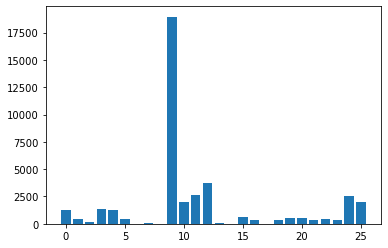

In [71]:
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [74]:
feature_names = ['region_code', 'source_type', 'basin', 'region', 'region_code', 'district_code',\
                   'public_meeting', 'scheme_management', 'permit', 'construction_year', 'extraction_type',\
                  'extraction_type_group', 'extraction_type_class','management',\
                   'management_group', 'payment', 'payment_type', 'water_quality',\
                  'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
                   'source_class', 'waterpoint_type', 'waterpoint_type_group']

In [75]:
mask = fs.scores_ > 1000
new_features = []
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)

In [73]:
new_features

[]

In [300]:
categorical_transformer = OneHotEncoder(handle_unknown = 'ignore')

preprocessor = ColumnTransformer([('cat', categorical_transformer, new_features)])

clf = Pipeline([('preprocessor', preprocessor), 
               ('classifier', RandomForestClassifier())])

clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['region_code', 'region',
                                                   'region_code',
                                                   'construction_year',
                                                   'extraction_type',
                                                   'extraction_type_group',
                                                   'extraction_type_class',
                                                   'waterpoint_type',
                                                   'waterpoint_type_group'])])),
                ('classifier', RandomForestClassifier())])

In [301]:
clf.score(X_train, y_train)

0.7289562289562289

In [ ]:
RandomForestClassifier()

In [ ]:
param_grid = {
 'classifier__bootstrap': [True, False],
 'classifier__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'classifier__criterion': ['gini', 'entropy'],
 'classifier__max_features': ['auto', 'sqrt'],
 'classifier__min_samples_leaf': [1, 2, 4],
 'classifier__min_samples_split': [2, 5, 10],
 'classifier__n_estimators': [200, 400, 600, 800, 1000]
}

grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv = 5, return_train_score=True)

grid_search.fit(X_train, y_train)